In [1]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
por_df.shape

(649, 33)

In [89]:
### Query Setup
SAMPLES = 500

true_result = por_df['absences'].agg(['count','sum', 'mean', 'var']).to_numpy()

def generate_samples() -> List[np.ndarray]:
    def run_query(i: int):
        temp_df = por_df.sample(frac=0.5)
        out_df = temp_df['absences'].agg(['count','sum', 'mean', 'var'])
        out_df['count'] *= 2
        out_df['sum'] *= 2
        return out_df.to_numpy()

    with concurrent.futures.ThreadPoolExecutor() as executor:
        out_np: List[np.ndarray] = list(executor.map(run_query, range(SAMPLES)))

    return out_np

In [90]:
out_np = generate_samples()

In [91]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

def do_pac_and_release(out_np: List[np.ndarray], max_mi: float = 1./4) -> np.ndarray:
    dimensions: int = len(out_np[0])
    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)

    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

In [92]:
do_pac_and_release(out_np)

array([  648.        , -9051.68586818,    55.13833244,   255.16907514])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [131]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/64]
EXPERIMENTS = 500

df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
experiment_results = []

for e in range(EXPERIMENTS):
    for mi in MI_OPTIONS: 
        out_np = generate_samples()
        noisy_output = do_pac_and_release(out_np, mi)
        experiment_results.append([mi, *noisy_output])

In [132]:
df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean', 'var'])
df.head()

,mi,count,sum,mean,var
0,16.00,648.0,3007.269320,3.454218,30.681478
1,4.00,648.0,4611.601458,6.223124,56.980608
2,2.00,648.0,3041.945306,-3.823065,23.998834
3,1.00,648.0,904.992937,1.628542,19.638230
4,0.25,648.0,-5254.929111,-36.296035,938.557493


In [133]:
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

def get_errors_from_row(row: pd.Series, true_result: np.ndarray) -> np.ndarray:
    est = row[['count', 'sum', 'mean', 'var']].to_numpy()
    return [absolute_scaled_error(est, true_result), relative_error_percent(est, true_result)]

errors_list = []
for i, row in df.iterrows():
    mi = row['mi']
    r = row[['count', 'sum', 'mean', 'var']].to_numpy()
    errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
errors_df = pd.DataFrame(errors_list, columns=['mi', 'absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var', 'relative error count', 'relative error sum', 'relative error mean', 'relative error var'])
errors_df.head()

,mi,absolute error count,absolute error sum,absolute error mean,absolute error var,relative error count,relative error sum,relative error mean,relative error var
0,16.00,1.0,632.269320,0.205258,9.144835,0.154083,26.621866,5.608939,42.461751
1,4.00,1.0,2236.601458,2.563648,35.443966,0.154083,94.172693,70.055044,164.575171
2,2.00,1.0,666.945306,7.482542,2.462191,0.154083,28.081908,204.470294,11.432568
3,1.00,1.0,1470.007063,2.030934,1.898412,0.154083,61.895034,55.497938,8.814801
4,0.25,1.0,7629.929111,39.955511,917.020850,0.154083,321.260173,1091.836924,4257.956448


In [134]:
std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

In [135]:
mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
mean_df, std_df

(           count           sum       mean         var
 mi                                                   
 0.015625   648.0  34337.897855 -34.953456 -175.747552
 0.062500   648.0   6803.784139   4.677437 -101.005608
 0.250000   648.0   2145.870583   0.846093   37.598978
 1.000000   648.0   2775.224748   3.773224   23.009221
 2.000000   648.0   2410.154614   3.710812   21.021656
 4.000000   648.0   2413.522609   3.775832   21.830503
 16.000000  648.0   2391.546190   3.687638   21.435475,
            count            sum        mean          var
 mi                                                      
 0.015625     0.0  475023.388111  738.066154  8786.786621
 0.062500     0.0  113213.413926  182.030215  2443.504006
 0.250000     0.0   28446.921740   46.981089   557.647508
 1.000000     0.0    7426.783174   10.826289   141.709372
 2.000000     0.0    3679.720921    5.517890    71.016545
 4.000000     0.0    1816.712907    2.735130    35.519463
 16.000000    0.0     481.690590    0.73

In [136]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_23095/2394850326.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')


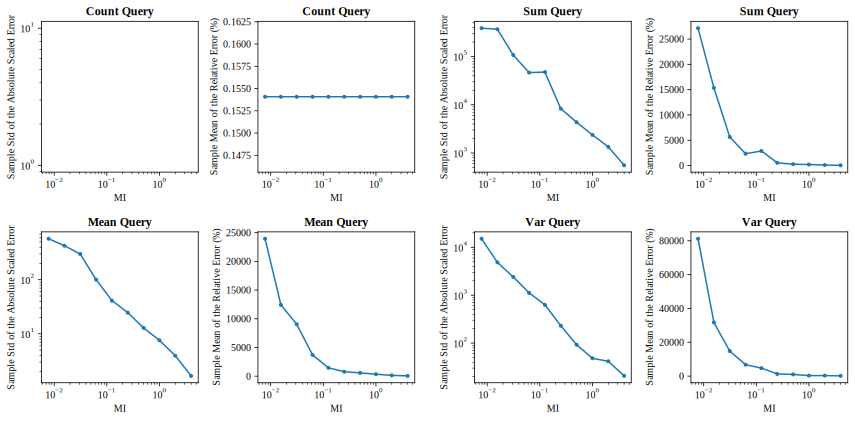

In [130]:
# ChatGPT graph code
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    ax1.plot(std_abs_error.index, std_abs_error[f'absolute error {query}'], label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    ax2.plot(sample_mean_rel_error.index, sample_mean_rel_error[f'relative error {query}'], label=query, marker='.')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

plt.tight_layout()
plt.show()